Import the necessary modules

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

import subprocess
import os
from pathlib import Path

from tqdm import tqdm

import gudhi as gd
from gudhi.point_cloud.timedelay import TimeDelayEmbedding

# import from own module
from knee_joints import Knee_Joints, Joints
from knee_joints import create_fig

set the parameter and the types of samples to be considered

In [2]:
periodicity = 100
number_steps = 1000
limit_plot = 1000
overwrite = False
redo = False

do_image_plots = True

params = {'folder': -1,
          'move_method': -1,
          'noise': 0,
          'bandwidth': 0,
          'time_updater': 1}

samples = [{'folder': 'images_smooth',
            'move_method': 'sinoidal'},
           # quicker pace
           {'folder': 'images_smooth_quick',
            'move_method': 'sinoidal',
            'time_updater': 5},
            # {'folder': 'images_smooth_quick',
            # 'move_method': 'sinoidal',
            # 'time_updater': 20},
           # noisy
           {'folder': 'images_noisy',
            'move_method': 'sinoidal_noise',
            'noise': 0.01},
           {'folder': 'images_noisy',
            'move_method': 'sinoidal_noise',
            'noise': 0.1},
           {'folder': 'images_last-point',
            'move_method': 'last_point',
            'noise': 0,
            'bandwidth': 0.1},
           # last point
           {'folder': 'images_last-point',
            'move_method': 'last_point',
            'noise': 0.1,
            'bandwidth': 0.1},
           {'folder': 'images_last-point',
            'move_method': 'last_point',
            'noise': 0.01,
            'bandwidth': 0.1},
           # skip
           {'folder': 'images_skip',
            'move_method': 'skip_overextension',
            'noise': 0,
            'bandwidth': 0.1},
           {'folder': 'images_skip',
            'move_method': 'skip_overextension',
            'noise': 0.1,
            'bandwidth': 0.1}
           ]

## Simulating joints

Perfom the simulation of the joints and save the resulting figures in the appropriate subfolder in `images` and the resulting array of x,y coordinates of each joint in `arrays`.

In this example the joints are:

> `kj = Knee_Joints(number_steps=periodicity)` 
> `kj.add_point_relative(xborder=[-0.25, 0.25])`
> `kj.add_point_relative(xborder=[-0.5, 0.5])`
> `kj.add_point_relative(xborder=[-1, 1])`

In [3]:
samples_pts = []
pbar = tqdm(samples)
# for folder, move_method, noise, bandwidth in pbar:
for sample in pbar:
    for i, key in enumerate(params):
        if key not in sample:
            if params[key] == -1:
                raise ValueError(f'{key} needs to be set!')
            else:
                sample[key] = params[key]

    # TODO need to copy these into the fields below
    folder = sample['folder']
    move_method = sample['move_method']
    noise = sample['noise']
    bandwidth = sample['bandwidth']
    time_updater = sample['time_updater']

    # find the right folder name and filename
    if noise > 0:
        folder = f'{folder}_{noise}'

    # if we have no noise and overwrite is not True take the next one
    if (((noise == 0 and not overwrite) or (not redo))
       and os.path.isdir(os.path.join('images', folder))
       and os.path.isfile(os.path.join('arrays', f'{folder}.npy'))):

        print(f'  {folder} exists already, skip')
        continue

    found_folder = False
    step = 1
    folder_loop = folder
    while not found_folder:
        if not os.path.isdir(os.path.join('images', folder_loop)):
            os.mkdir(os.path.join('images', folder_loop))
            found_folder = True
        elif not overwrite and os.path.isfile(os.path.join('images', 
                                                           f'{folder_loop}.npy')):
            folder_loop = f'{folder}_{step}'
            step += 1
        else:
            found_folder = True
    folder = folder_loop

    # update progressbar
    pbar.set_description(f'processing: {folder}')

    # construct the knee joint
    kj = Knee_Joints(number_steps=periodicity)
    kj.add_point_relative(xborder=[-0.25, 0.25])
    kj.add_point_relative(xborder=[-0.5, 0.5])
    kj.add_point_relative(xborder=[-1, 1])

    kj.save_current()

    for move in range(number_steps):
        kj.move_joint(method=move_method,
                      noise_size=noise,
                      bandwidth=bandwidth, 
                      time_updater=time_updater)

    points = kj.get_history_array()
    np.save(os.path.join('arrays', f'{folder}.npy'), points)
    samples_pts.append(points)

    if do_image_plots:
        n_joints = len(kj.points)
        bbox = kj.get_bounding_box()

        for j, points in enumerate(kj.history):
            if j >= limit_plot:
                break
            fig, ax = plt.subplots(1, 1, dpi=200)
            G = nx.Graph()

            keys = list(points.keys())
            G.add_nodes_from(keys)
            G.add_edges_from([(keys[i], keys[i+1])
                            for i in range(len(keys)-1)])

            pos = [points[key] for key in keys]
            nx.draw(G, pos, ax=ax)
            ax.set_title(' '.join(folder.split('_')[1:]))
            ax.set_xlim(left=bbox[0]-1, right=bbox[1]+1)
            ax.set_ylim(bottom=bbox[2]-1, top=bbox[3]+1)

            fig.savefig(os.path.join('images', f'./{folder}/movement_{j:04d}.png'))
            plt.close(fig)

processing: images_smooth_quick:   0%|          | 0/9 [00:00<?, ?it/s]

  images_smooth exists already, skip


processing: images_smooth_quick: 100%|██████████| 9/9 [00:45<00:00,  5.07s/it]

  images_noisy_0.01 exists already, skip
  images_noisy_0.1 exists already, skip
  images_last-point exists already, skip
  images_last-point_0.1 exists already, skip
  images_last-point_0.01 exists already, skip
  images_skip exists already, skip
  images_skip_0.1 exists already, skip


## Gif creation

Get the folder for which images and arrays were created and create the gif if the file doesn't already exist

In [4]:
# get the folders

folders = []
for item in Path('images').iterdir():
    if (item.is_dir()
       and str(item.name).startswith('images_')):
        # if not os.path.isfile(os.path.join('arrays', f'{item.name}.npy')):
        #     print(f"  {item.name} doesn't have an associated array!")
        # else:
        folders.append(item.name)

# get the gifs

pbar = tqdm(folders)
for folder in pbar:
    if not os.path.isfile(f'animation/anim_{folder}.gif'):
        pbar.set_description(f'processing: {folder}')
        call = ['convert', '-scale', '50%',
                '-delay', '10', '-loop', '0',
                f'images/{folder}/*.png', f'animation/anim_{folder}.gif']
        subprocess.call(call)

processing: images_smooth_quick:   0%|          | 0/9 [00:00<?, ?it/s]

## Persistence plots

In [ ]:
# get the folders

folders = []
for item in Path('arrays').iterdir():
    if (str(item.name).startswith('images_')
       and str(item.name).endswith('.npy')):
        folders.append(item.name)

# sort folders and put 'images_smooth' in 
# first position if it exists
folders.sort()
if 'images_smooth.npy' in folders:
    folders.remove('images_smooth.npy')
    folders.insert(0, 'images_smooth.npy')

samples_all = [(i,
                '_'.join(folders[i].split('_')[1:]),
                np.load(os.path.join('arrays', f'{folders[i]}')))
               for i in range(len(folders))]

print(folders)

['images_smooth.npy', 'images_last-point.npy', 'images_last-point_0.01.npy', 'images_last-point_0.1.npy', 'images_noisy_0.01.npy', 'images_noisy_0.1.npy', 'images_skip.npy', 'images_skip_0.1.npy', 'images_smooth_quick.npy']


Get the distances between consective slices for each of the samples and their embedded point clouds

In [ ]:
l2 = []
for _, _, points_plot in samples_all:
    l2.append([np.linalg.norm(points_plot[i+1] - points_plot[i])
               for i in range(points_plot.shape[0]-1)])

tc_embed = TimeDelayEmbedding()
pc_taken = tc_embed.transform(l2)

### Now plot the persistence diagrams (and calculate the persistence):

Distances between consecutive x,y positions for different times.

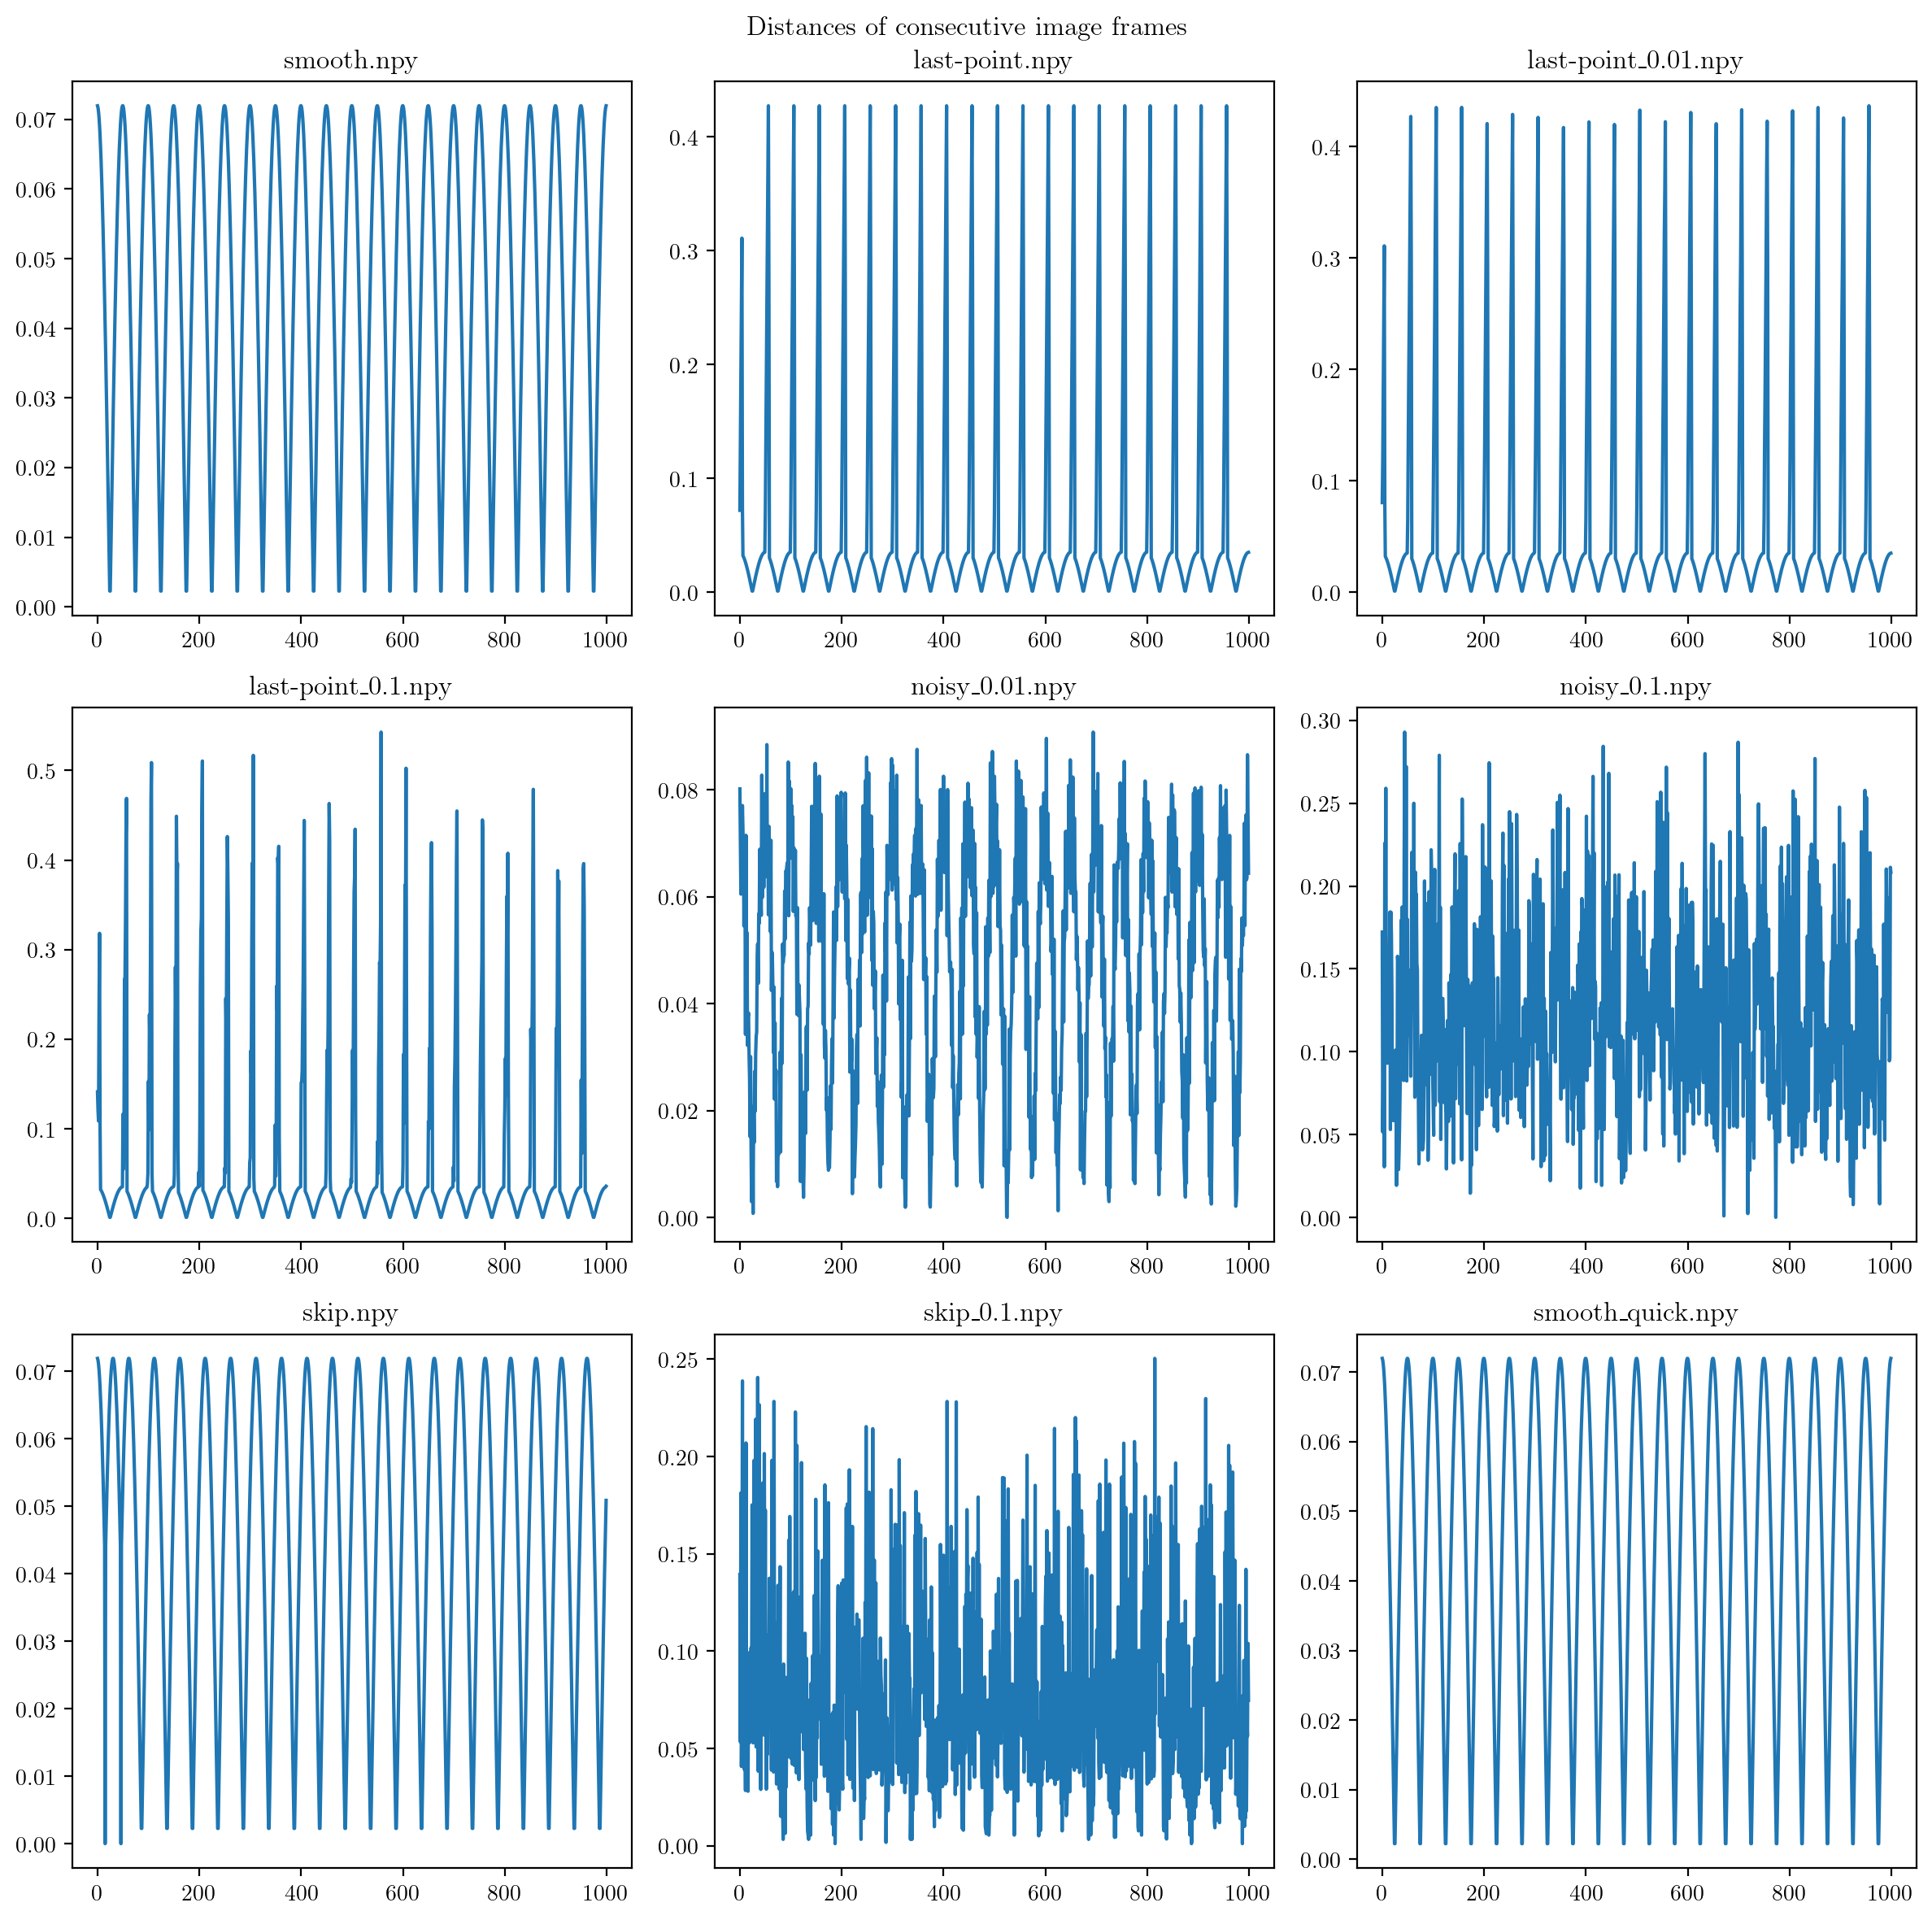

In [ ]:
fig, ax_list = create_fig(samples_all)

for i in range(len(samples_all)):
    ax_list[i].plot(range(len(l2[i])), l2[i])
    ax_list[i].set_title(samples_all[i][1])

for i in range(len(samples_all), len(ax_list)):
    ax_list[i].remove()

fig.suptitle('Distances of consecutive image frames')
fig.tight_layout()
fig.savefig('plots/distance_bw_consecutive_frames.png')

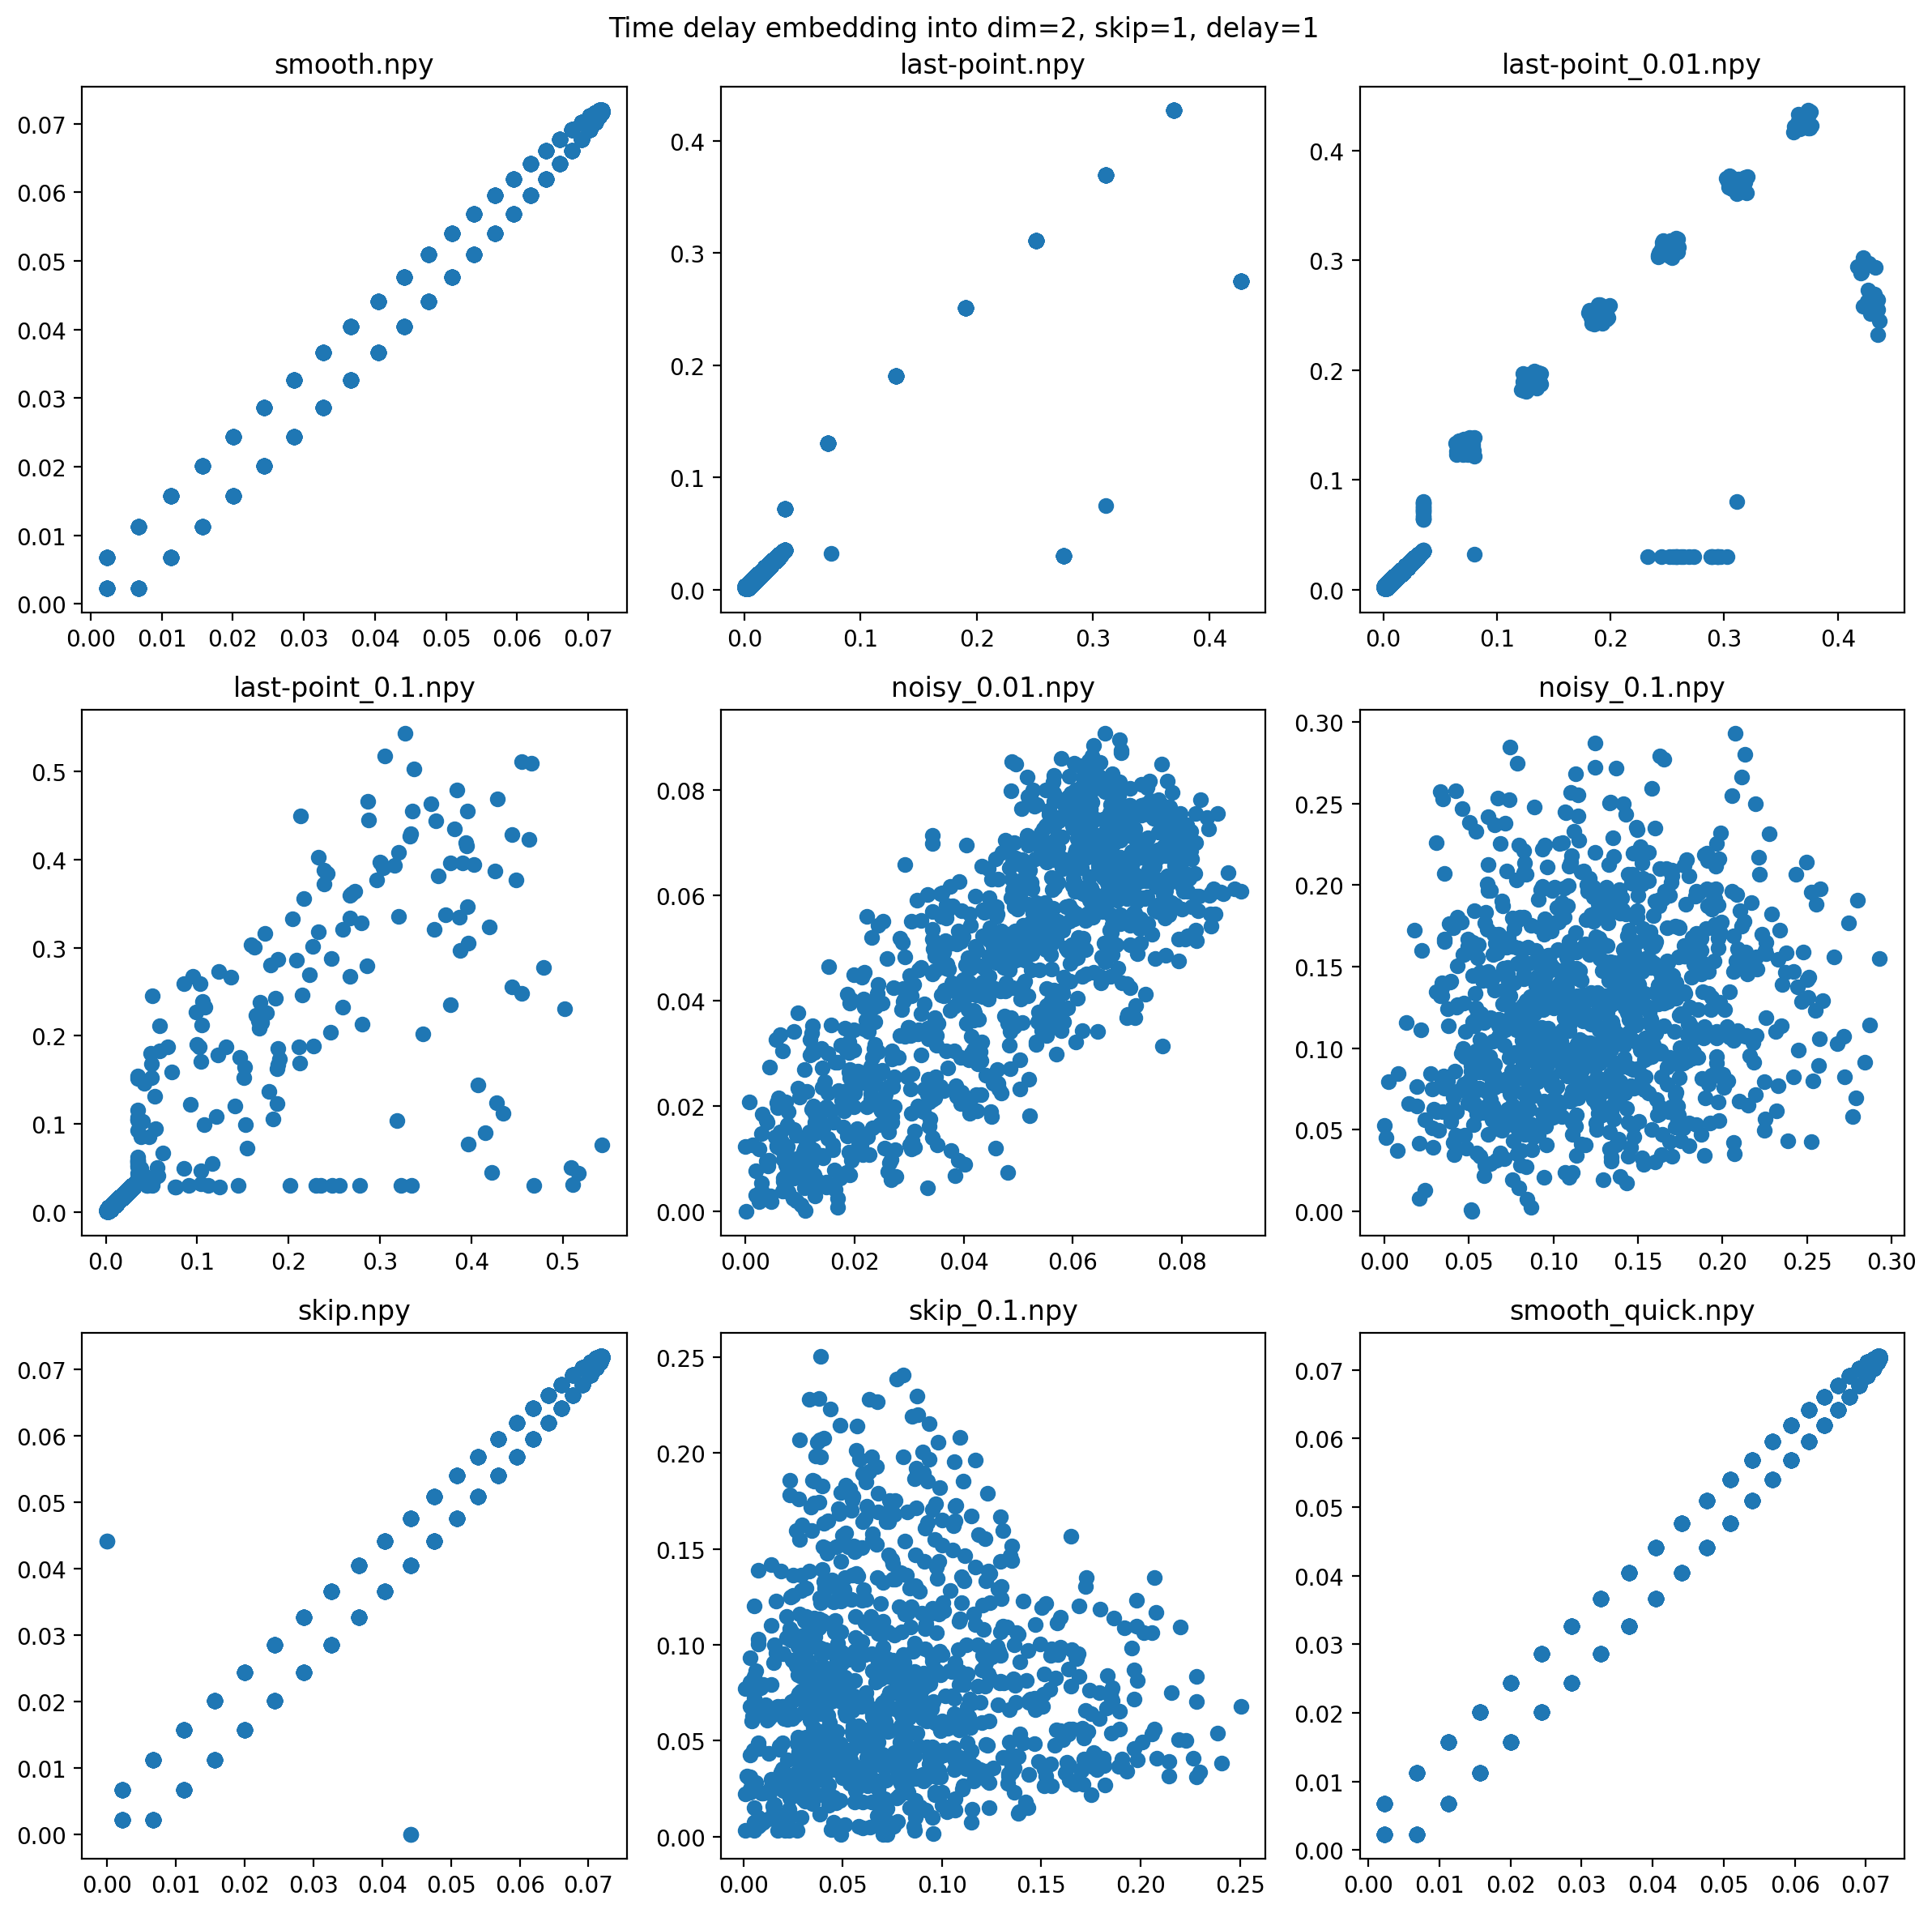

In [ ]:
fig, ax_list = create_fig(samples_all)

for i in range(len(samples_all)):
    ax_list[i].scatter(pc_taken[i][:, 0], pc_taken[i][:, 1])
    ax_list[i].set_title(samples_all[i][1])

for i in range(len(samples_all), len(ax_list)):
    ax_list[i].remove()

fig.suptitle('Time delay embedding into dim=2, skip=1, delay=1')
fig.tight_layout()
fig.savefig('plots/time_delay_consecutive_frames.png')

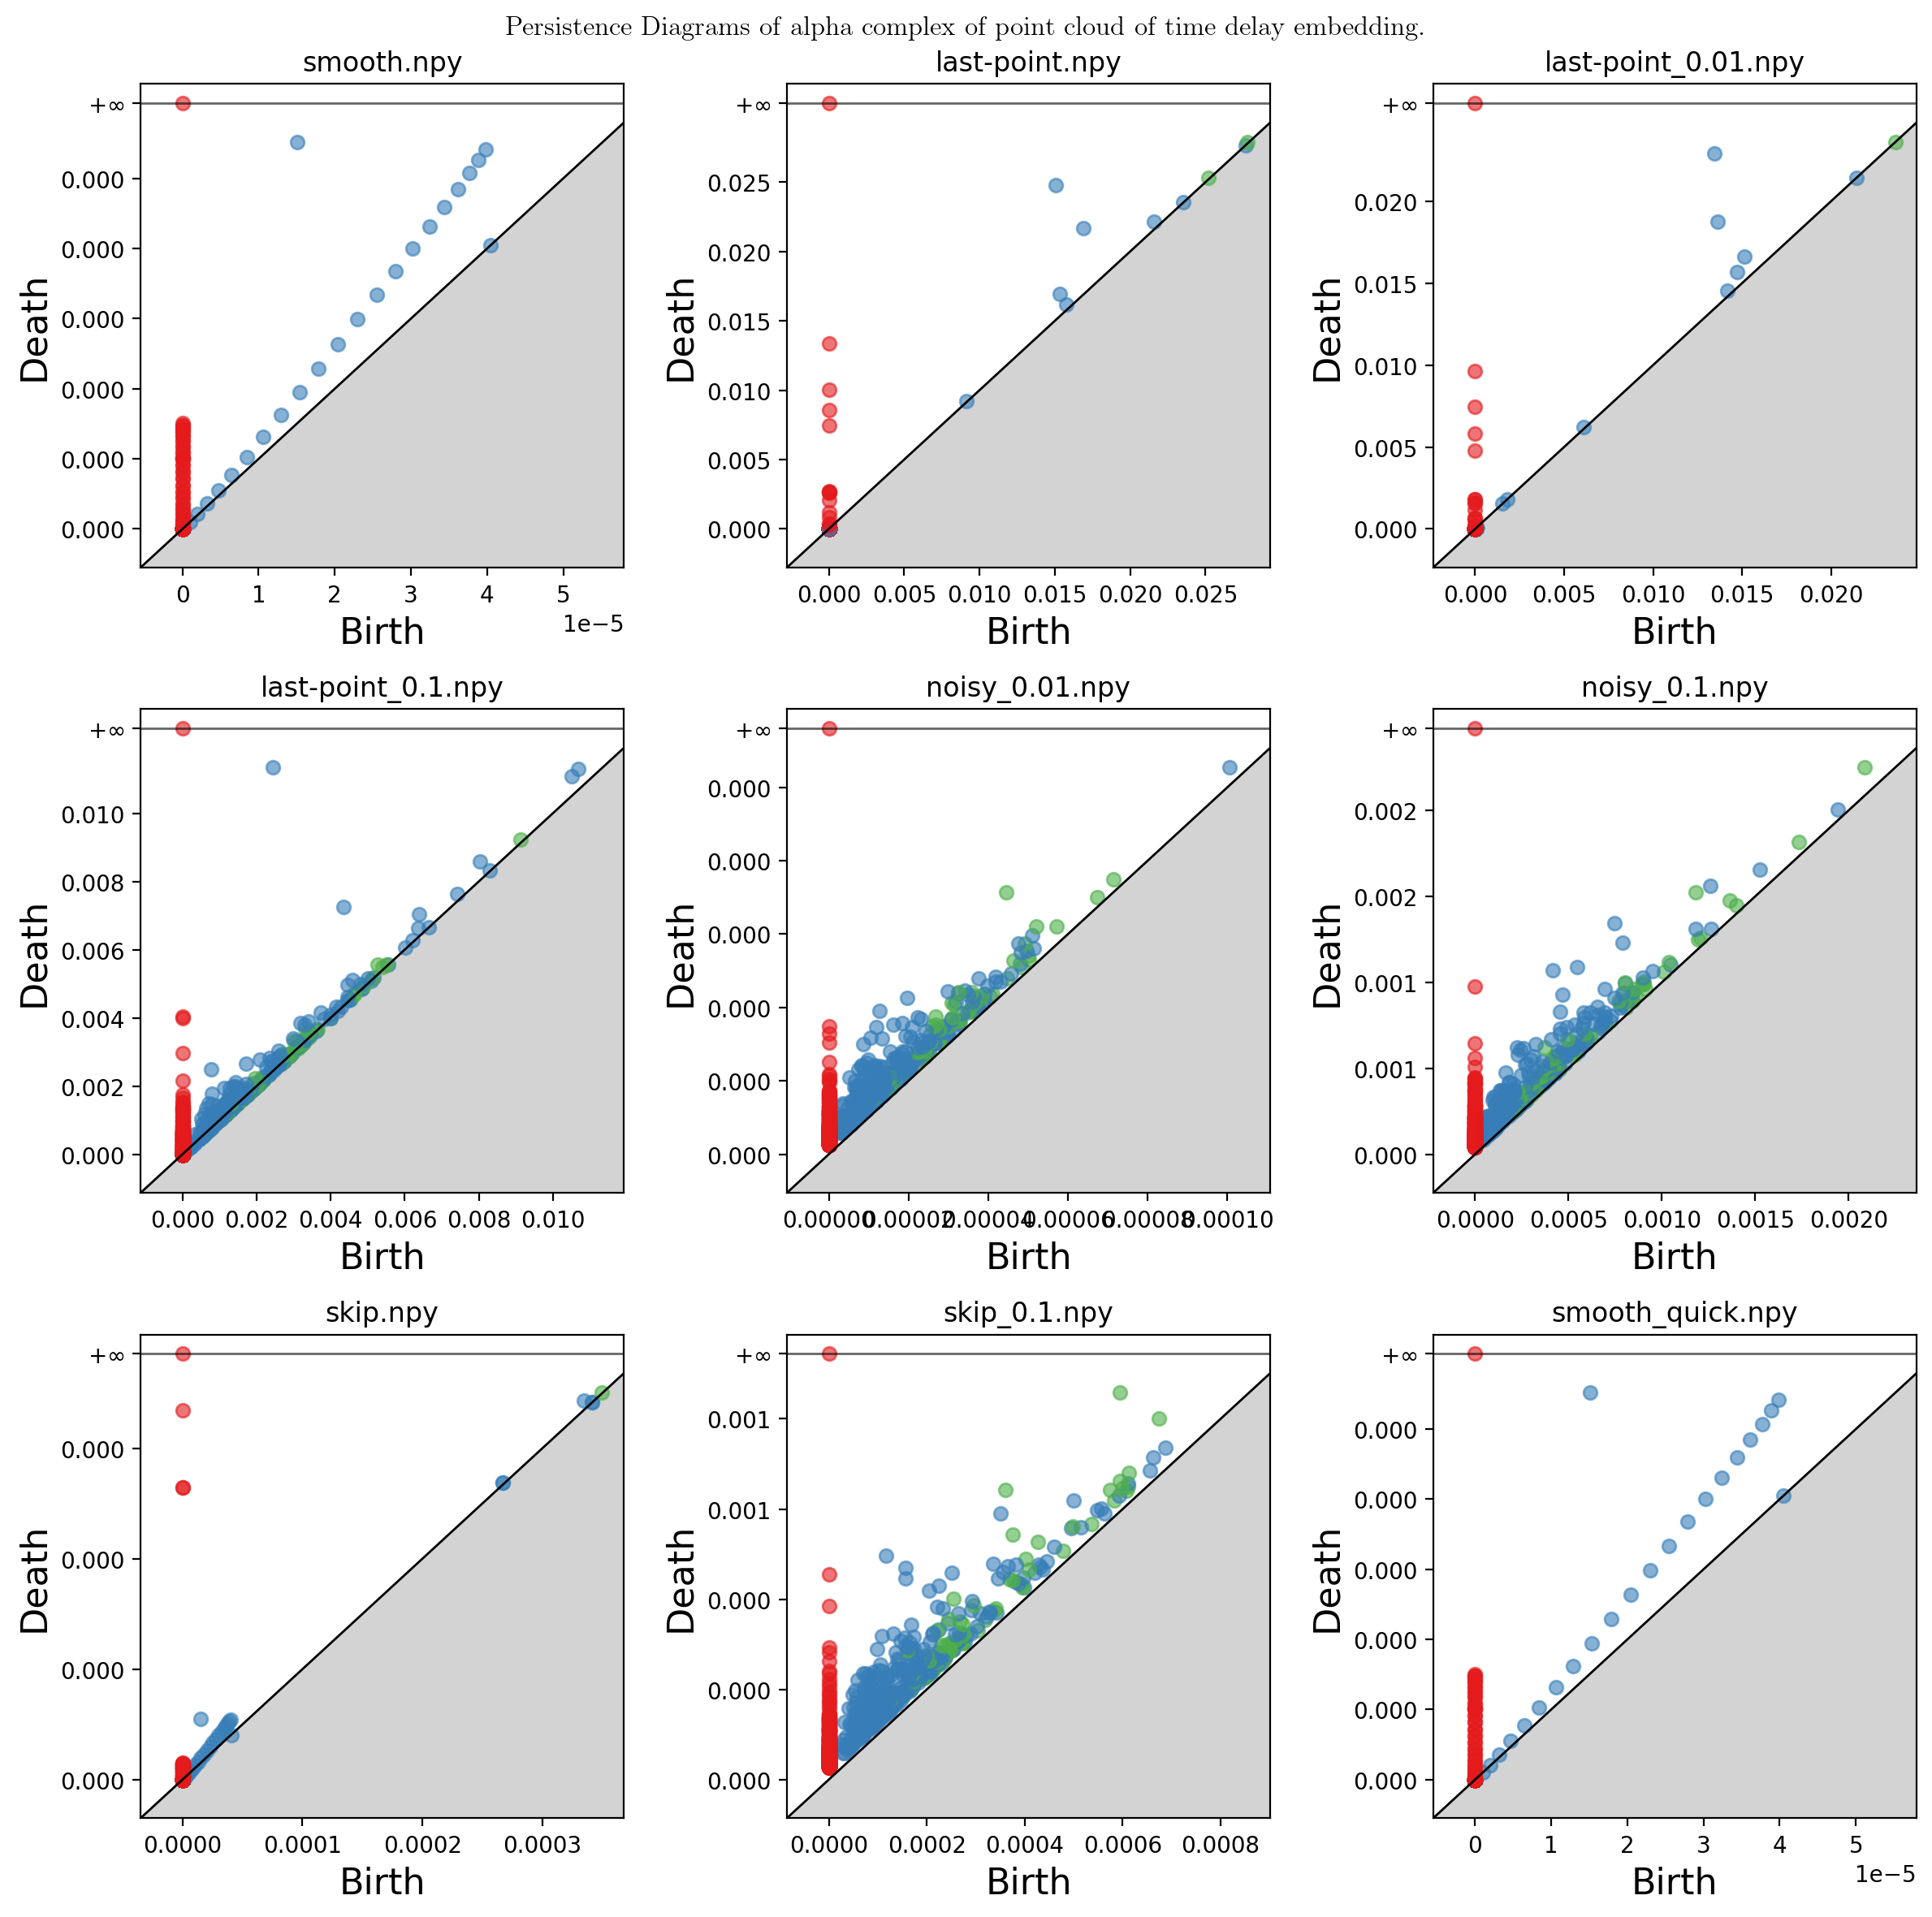

In [ ]:
fig, ax_list = create_fig(samples_all)

for i, txt, _ in samples_all:
    acX = gd.AlphaComplex(points=pc_taken[i]).create_simplex_tree()
    dgmX = acX.persistence()
    gd.plot_persistence_diagram(dgmX, axes=ax_list[i])
    ax_list[i].set_title(txt)

for i in range(len(samples_all), len(ax_list)):
    ax_list[i].remove()

fig.suptitle('Persistence Diagrams of alpha complex of point cloud of time delay embedding.')
fig.tight_layout()
fig.savefig('plots/alpha_timedelay.png')

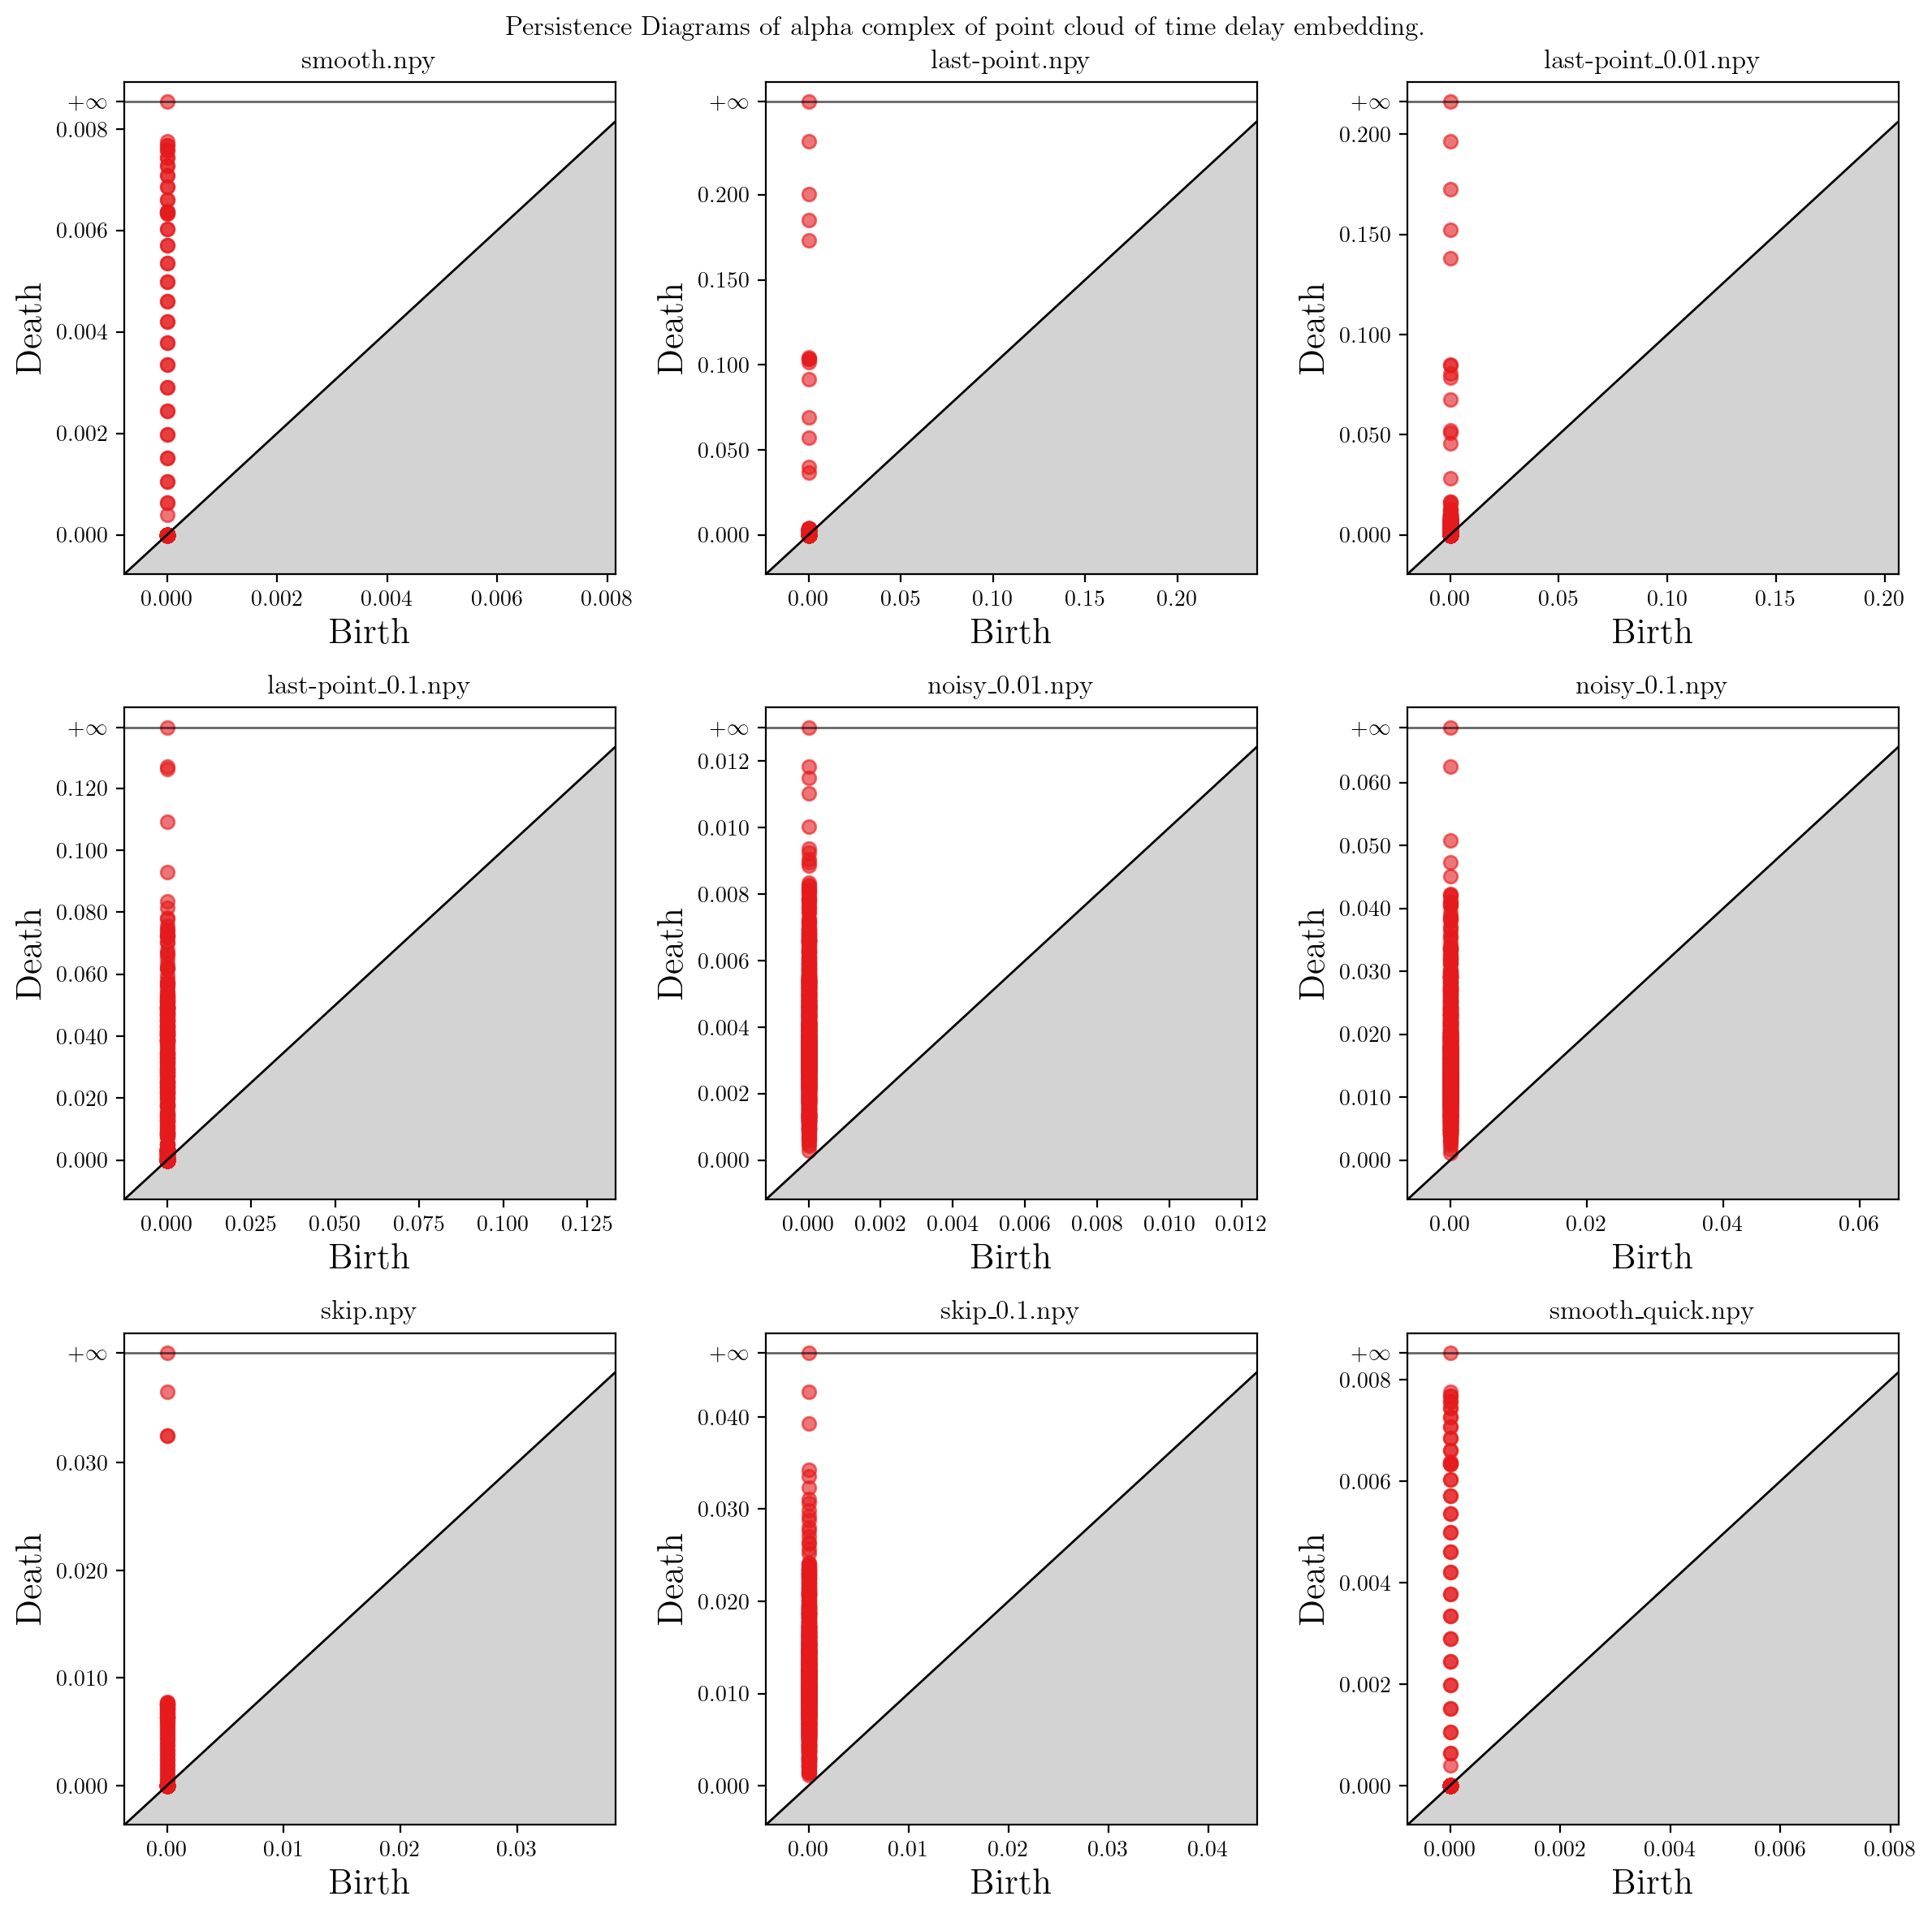

In [ ]:
fig, ax_list = create_fig(samples_all)

for i, txt, _ in samples_all:
    acX = gd.RipsComplex(points=pc_taken[i]).create_simplex_tree()
    dgmX = acX.persistence()
    gd.plot_persistence_diagram(dgmX, axes=ax_list[i])
    ax_list[i].set_title(txt)

for i in range(len(samples_all), len(ax_list)):
    ax_list[i].remove()

fig.suptitle('Persistence Diagrams of alpha complex of point cloud of time delay embedding.')
fig.tight_layout()
fig.savefig('plots/VR_timedelay.png')

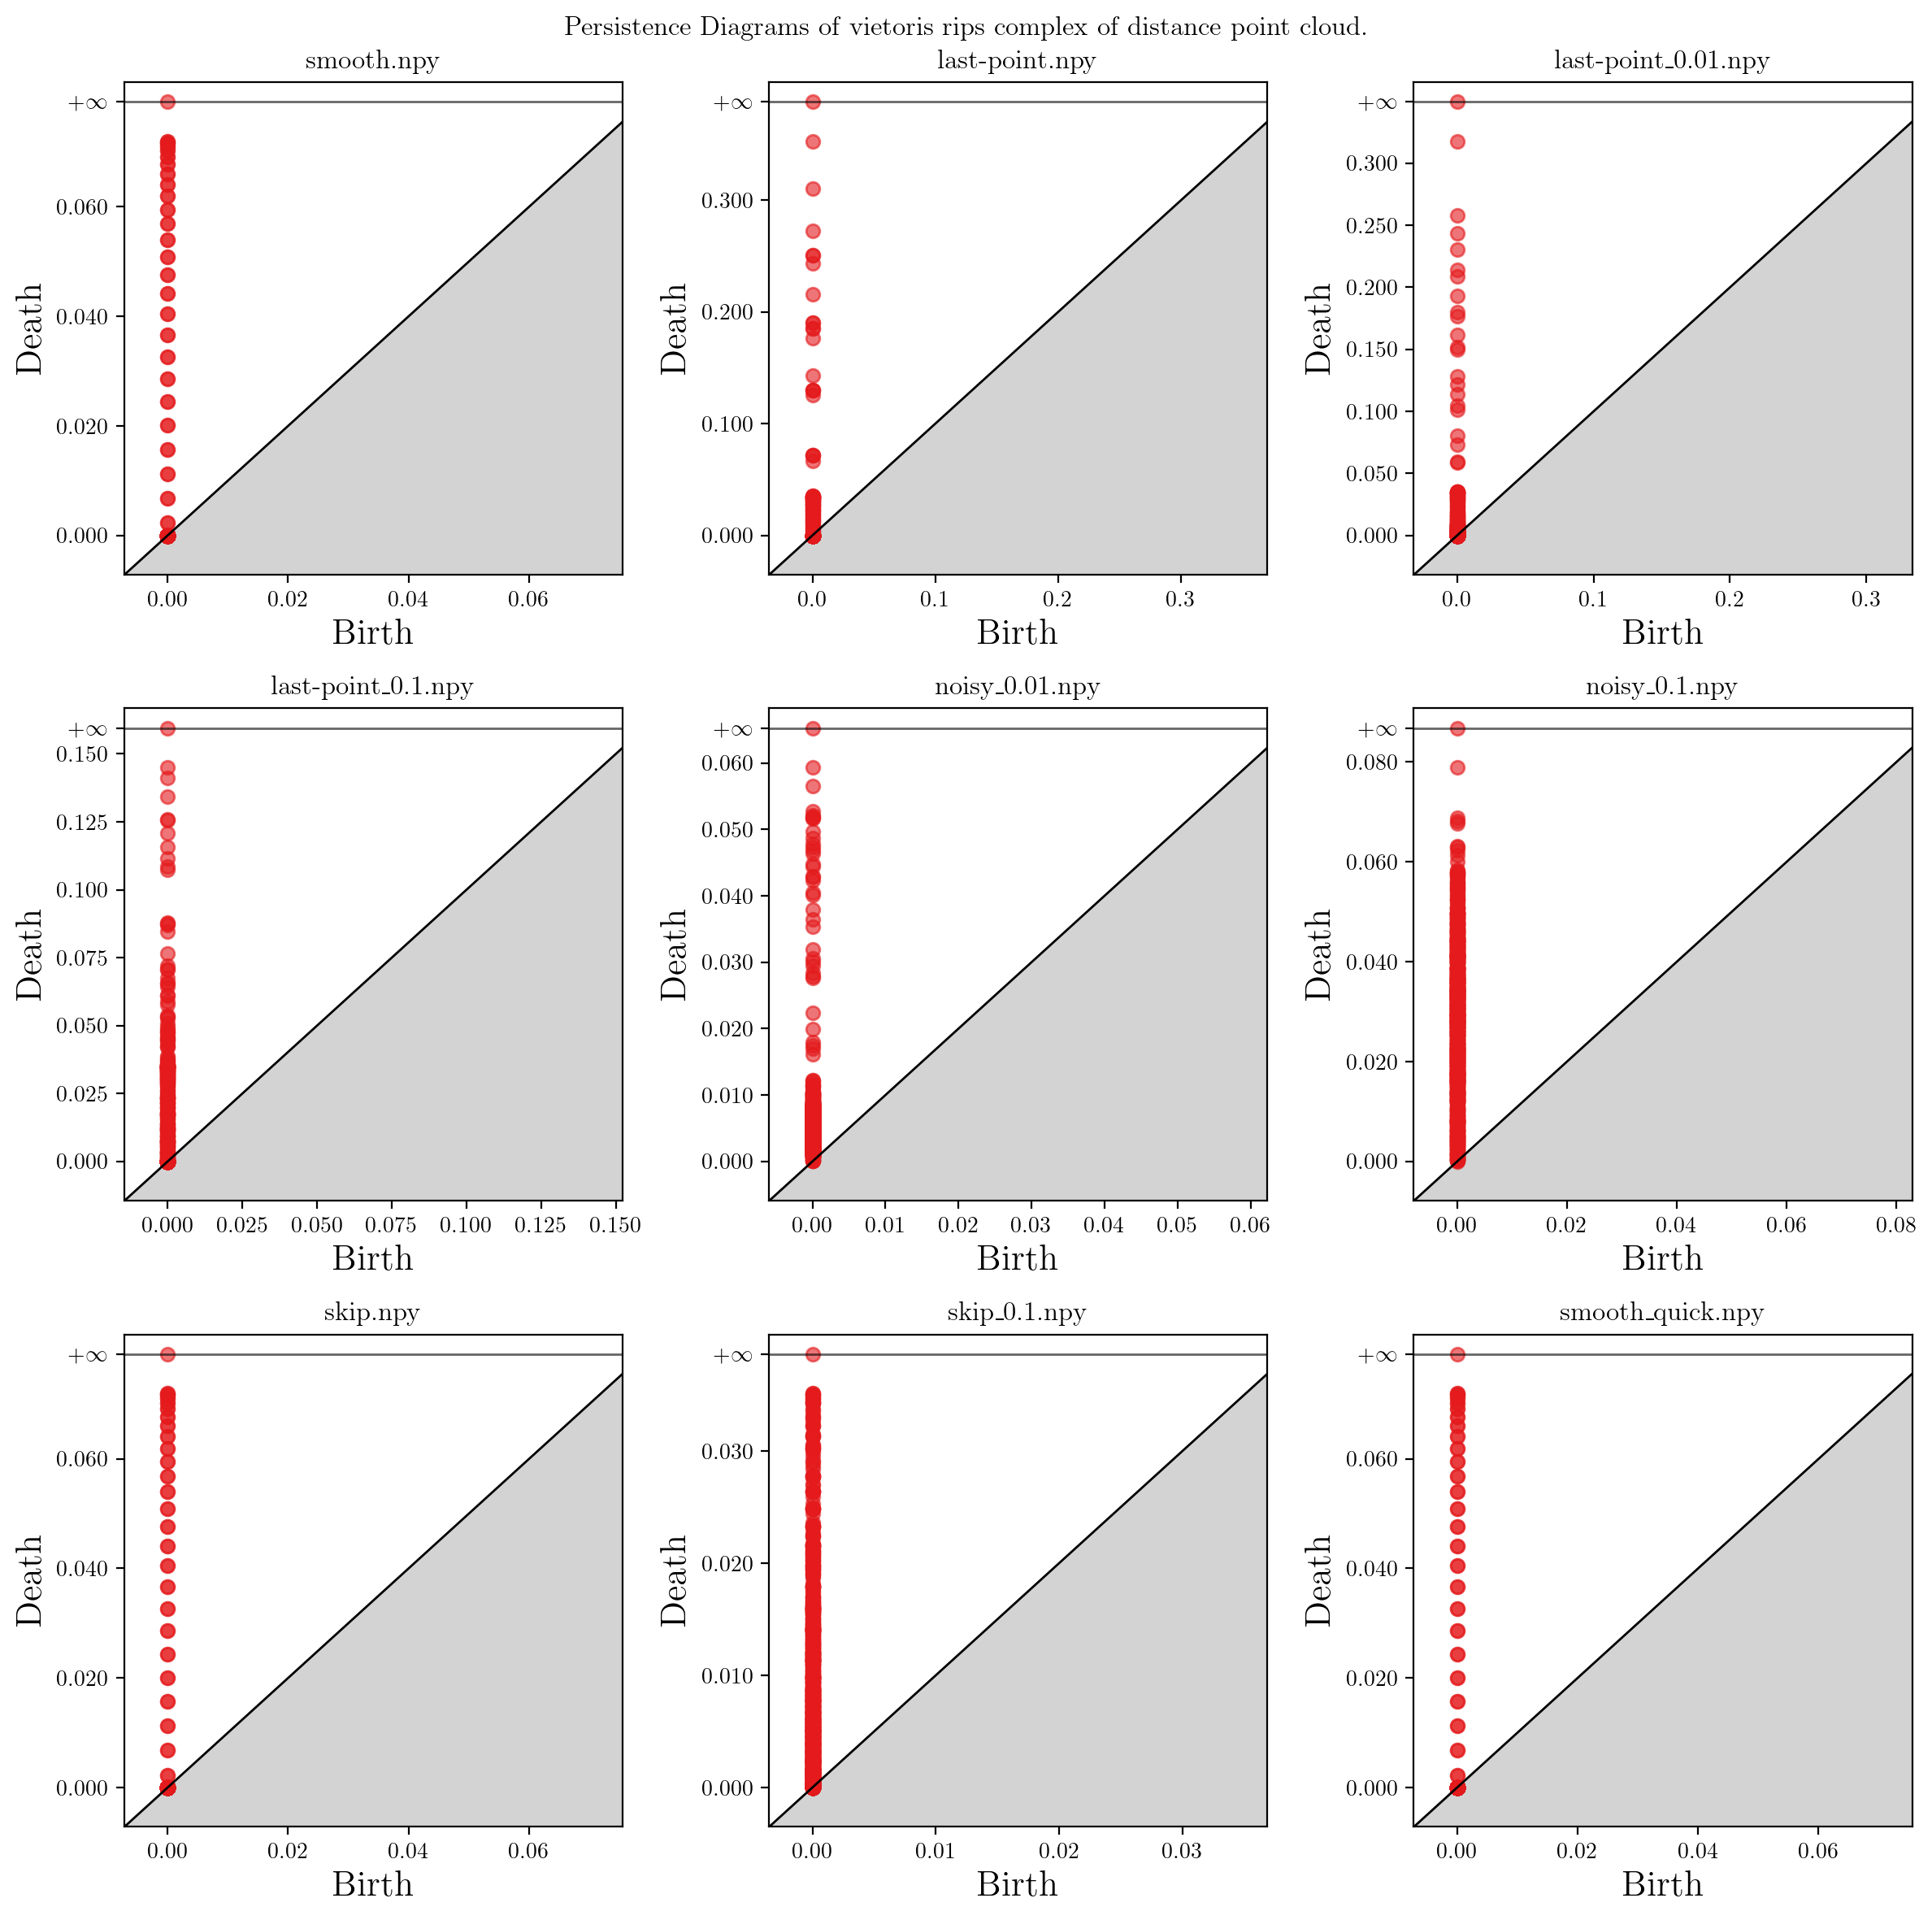

In [ ]:
fig, ax_list = create_fig(samples_all)

for k, txt, points_plot in samples_all:
    dist_mat = np.zeros([len(points_plot), len(points_plot)])
    for i in range(len(points_plot)):
        for j in range(i+1, len(points_plot)):
            dist_mat[i, j] = np.linalg.norm(points_plot[i] - points_plot[j])
            dist_mat[j, i] = dist_mat[i, j]

    acX = gd.RipsComplex(distance_matrix=dist_mat).create_simplex_tree()
    dgmX = acX.persistence()
    gd.plot_persistence_diagram(dgmX, axes=ax_list[k])

    ax_list[k].set_title(txt)

for i in range(len(samples_all), len(ax_list)):
    ax_list[i].remove()

fig.suptitle('Persistence Diagrams of vietoris rips complex'
             + ' of distance point cloud.')
fig.tight_layout()
fig.savefig('plots/VR_pwDistances.png')